In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
import tensorflow as tf
import talib
from tensorflow import keras
from sklearn.pipeline import make_pipeline
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping

In [2]:
data=yf.download('0700.hk','2018-01-01','2022-04-09')

[*********************100%***********************]  1 of 1 completed


In [3]:
data['6day MA'] = data['Close'].rolling(window = 6).mean()
data['12day MA'] = data['Close'].rolling(window = 12).mean()
data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
data['%R5'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 5)
data['%R10'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 10)
data['MI6']=talib.MOM(data['Close'],timeperiod=6)
data['MI12']=talib.MOM(data['Close'],timeperiod=12)
macd, macdsignal, macdhist = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['EMA12']=talib.EMA(data['Close'], timeperiod=12)
data['EMA26']=talib.EMA(data['Close'],timeperiod=26)
data['MACD']=macd
data['TR']=talib.TRANGE(data['High'],data['Low'],data['Close'])
data['OSC6']=talib.CMO(data['Close'], timeperiod=6)
data['OSC12']=talib.CMO(data['Close'], timeperiod=12)
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)

In [4]:
# data=data[data.columns[list(backwardModel.k_feature_idx_)]]
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)
data_val=data[-100:]
data=data[:-100]
data.head()

,Open,High,Low,Close,Adj Close,Volume,6day MA,12day MA,RSI,%R5,%R10,MI6,MI12,EMA12,EMA26,MACD,TR,OSC6,OSC12,Prediction
Date,,,,,,,,,,,,,,,,,,,,
2018-02-20,450.000000,453.000000,444.799988,445.799988,441.189606,20482027,427.633331,430.349998,60.259196,-16.589892,-13.090931,25.599976,-17.800018,434.798151,437.879982,-0.648021,8.200012,25.906129,11.146963,458.000000
2018-02-21,448.600006,458.000000,447.200012,458.000000,453.263489,20404622,436.066666,430.183332,67.717778,-0.000000,-0.000000,50.600006,-2.000000,438.367666,439.370354,1.056690,12.200012,42.030785,21.297763,446.399994
2018-02-22,455.000000,455.200012,446.399994,446.399994,441.783447,22385045,442.199997,429.683332,56.048848,-36.708873,-19.333344,36.799988,-6.000000,439.603409,439.891068,1.454891,11.600006,13.778813,8.446917,453.399994
2018-02-23,454.000000,454.600006,449.399994,453.399994,448.710999,14992072,447.366664,430.716665,60.803925,-28.395078,-7.666677,31.000000,12.399994,441.725960,440.891729,2.308697,8.200012,24.634557,14.415901,453.000000
2018-02-26,456.000000,457.000000,448.399994,453.000000,448.315155,21252148,450.599996,434.299998,60.368513,-37.878753,-8.333333,19.399994,43.000000,443.460428,441.788638,2.919415,8.600006,23.567747,13.952778,446.000000


In [5]:
sc = MinMaxScaler(feature_range = (-1, 1))
# X=sc.fit_transform(data.drop('Prediction',1))
X=data.drop('Prediction',1)
Y = data["Prediction"].values.reshape(-1,1)


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_61294/237670532.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=data.drop('Prediction',1)


/opt/homebrew/Caskroom/miniforge/base/envs/fyp_new/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


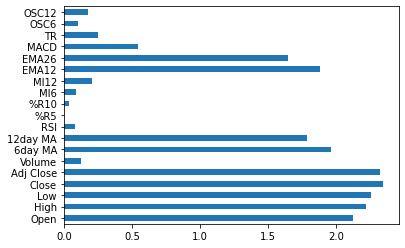

In [6]:
from sklearn.feature_selection import mutual_info_regression
importance=mutual_info_regression(X,Y)
feature_importances=pd.Series(importance,data.columns[0:len(data.columns)-1])
feature_importances.plot(kind="barh")
plt.show()

In [7]:
X=sc.fit_transform(data.drop(['Prediction','OSC12','OSC6','MI12','MI6','Volume','%R10','%R5','RSI','TR'],1))
# Y=np.array(data["Close"])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,shuffle=False)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(734, 1, 10) (734, 1) (184, 1, 10) (184, 1)


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_61294/512912998.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=sc.fit_transform(data.drop(['Prediction','OSC12','OSC6','MI12','MI6','Volume','%R10','%R5','RSI','TR'],1))


In [8]:
model_tech = keras.Sequential()
model_tech.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2]),
    return_sequences=True,
#     kernel_regularizer=regularizers.l1(0.01)
    
))
model_tech.add(keras.layers.LSTM(units=64))
model_tech.add(keras.layers.Dense(units=64))
model_tech.add(keras.layers.Dense(units=1))
model_tech.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

Metal device set to: Apple M1 Pro


2022-04-12 22:23:30.050862: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-12 22:23:30.051010: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0.001)
history_tech=model_tech.fit(
    X_train, y_train,
    epochs=500,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False,
)
y_pred = model_tech.predict(X_test)

Epoch 1/500


2022-04-12 22:23:30.498403: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-12 22:23:31.833683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 22:23:32.054105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 22:23:32.091048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 22:23:32.161696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 22:23:32.229645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 3s 27ms/step - loss: 151647.6250 - val_loss: 382483.1875
Epoch 2/500
 1/42 [..............................] - ETA: 0s - loss: 194525.9062

2022-04-12 22:23:33.466813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 22:23:33.548211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 22:23:33.575045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 0s 11ms/step - loss: 128971.7656 - val_loss: 388433.7812
Epoch 3/500
42/42 [==============================] - 1s 14ms/step - loss: 83945.3203 - val_loss: 393405.5312
Epoch 4/500
42/42 [==============================] - 0s 10ms/step - loss: 50002.1914 - val_loss: 396821.0625
Epoch 5/500
42/42 [==============================] - 0s 10ms/step - loss: 28762.5293 - val_loss: 391471.0938
Epoch 6/500
42/42 [==============================] - 0s 10ms/step - loss: 17367.1699 - val_loss: 358392.9375
Epoch 7/500
42/42 [==============================] - 0s 11ms/step - loss: 11867.3770 - val_loss: 292738.1250
Epoch 8/500
42/42 [==============================] - 0s 10ms/step - loss: 9431.2910 - val_loss: 225737.9531
Epoch 9/500
42/42 [==============================] - 1s 13ms/step - loss: 8213.1064 - val_loss: 174530.0000
Epoch 10/500
42/42 [==============================] - 1s 12ms/step - loss: 7485.9097 - val_loss: 137908.1094
Epoch 11/500
42/42 [============

Epoch 79/500
42/42 [==============================] - 0s 11ms/step - loss: 96.7228 - val_loss: 6878.2529
Epoch 80/500
42/42 [==============================] - 1s 13ms/step - loss: 95.9028 - val_loss: 6831.9766
Epoch 81/500
42/42 [==============================] - 0s 11ms/step - loss: 95.1057 - val_loss: 6785.5610
Epoch 82/500
42/42 [==============================] - 0s 11ms/step - loss: 94.3320 - val_loss: 6739.0142
Epoch 83/500
42/42 [==============================] - 0s 11ms/step - loss: 93.5823 - val_loss: 6692.3438
Epoch 84/500
42/42 [==============================] - 0s 11ms/step - loss: 92.8575 - val_loss: 6645.5625
Epoch 85/500
42/42 [==============================] - 0s 11ms/step - loss: 92.1585 - val_loss: 6598.6797
Epoch 86/500
42/42 [==============================] - 0s 11ms/step - loss: 91.4868 - val_loss: 6551.7021
Epoch 87/500
42/42 [==============================] - 0s 10ms/step - loss: 90.8439 - val_loss: 6504.6396
Epoch 88/500
42/42 [==============================] - 0

42/42 [==============================] - 0s 10ms/step - loss: 76.5869 - val_loss: 4704.1006
Epoch 157/500
42/42 [==============================] - 0s 11ms/step - loss: 73.8549 - val_loss: 4580.7485
Epoch 158/500
42/42 [==============================] - 0s 11ms/step - loss: 92.1359 - val_loss: 4391.7612
Epoch 159/500
42/42 [==============================] - 1s 12ms/step - loss: 142.3002 - val_loss: 4261.2446
Epoch 160/500
42/42 [==============================] - 0s 12ms/step - loss: 181.6744 - val_loss: 4269.2397
Epoch 161/500
42/42 [==============================] - 1s 12ms/step - loss: 179.5380 - val_loss: 4384.6670
Epoch 162/500
42/42 [==============================] - 0s 11ms/step - loss: 169.3859 - val_loss: 4581.0244
Epoch 163/500
42/42 [==============================] - 0s 11ms/step - loss: 164.4871 - val_loss: 4794.8433
Epoch 164/500
42/42 [==============================] - 0s 11ms/step - loss: 156.3421 - val_loss: 4909.9648
Epoch 165/500
42/42 [==============================] -

42/42 [==============================] - 0s 11ms/step - loss: 131.7615 - val_loss: 4408.3633
Epoch 234/500
42/42 [==============================] - 0s 10ms/step - loss: 132.9415 - val_loss: 4562.5493
Epoch 235/500
42/42 [==============================] - 0s 11ms/step - loss: 110.8155 - val_loss: 4537.3887
Epoch 236/500
42/42 [==============================] - 0s 10ms/step - loss: 80.6242 - val_loss: 4345.3755
Epoch 237/500
42/42 [==============================] - 0s 10ms/step - loss: 90.5758 - val_loss: 4110.7349
Epoch 238/500
42/42 [==============================] - 0s 10ms/step - loss: 127.2921 - val_loss: 4011.9668
Epoch 239/500
42/42 [==============================] - 0s 11ms/step - loss: 124.7592 - val_loss: 4087.0078
Epoch 240/500
42/42 [==============================] - 0s 12ms/step - loss: 105.3423 - val_loss: 4255.6025
Epoch 241/500
42/42 [==============================] - 0s 10ms/step - loss: 104.8534 - val_loss: 4413.9951
Epoch 242/500
42/42 [==============================] 

42/42 [==============================] - 0s 12ms/step - loss: 80.3194 - val_loss: 4402.2852
Epoch 311/500
42/42 [==============================] - 0s 10ms/step - loss: 69.7059 - val_loss: 4238.8784
Epoch 312/500
42/42 [==============================] - 0s 10ms/step - loss: 80.9361 - val_loss: 4040.4592
Epoch 313/500
42/42 [==============================] - 0s 10ms/step - loss: 101.4781 - val_loss: 3924.3945
Epoch 314/500
42/42 [==============================] - 0s 10ms/step - loss: 104.6828 - val_loss: 3957.7527
Epoch 315/500
42/42 [==============================] - 0s 10ms/step - loss: 95.4363 - val_loss: 4104.5527
Epoch 316/500
42/42 [==============================] - 0s 10ms/step - loss: 92.2808 - val_loss: 4277.8247
Epoch 317/500
42/42 [==============================] - 0s 10ms/step - loss: 90.4993 - val_loss: 4392.7114
Epoch 318/500
42/42 [==============================] - 0s 10ms/step - loss: 81.8030 - val_loss: 4401.0894
Epoch 319/500
42/42 [==============================] - 0s 

42/42 [==============================] - 0s 10ms/step - loss: 89.3566 - val_loss: 4464.4580
Epoch 388/500
42/42 [==============================] - 0s 10ms/step - loss: 80.9938 - val_loss: 4482.2544
Epoch 389/500
42/42 [==============================] - 0s 10ms/step - loss: 70.1537 - val_loss: 4382.3945
Epoch 390/500
42/42 [==============================] - 0s 10ms/step - loss: 70.6851 - val_loss: 4191.3301
Epoch 391/500
42/42 [==============================] - 0s 10ms/step - loss: 86.5919 - val_loss: 3990.2822
Epoch 392/500
42/42 [==============================] - 0s 10ms/step - loss: 101.6516 - val_loss: 3897.0190
Epoch 393/500
42/42 [==============================] - 0s 10ms/step - loss: 100.2081 - val_loss: 3964.9512
Epoch 394/500
42/42 [==============================] - 0s 10ms/step - loss: 92.4928 - val_loss: 4145.9424
Epoch 395/500
42/42 [==============================] - 0s 11ms/step - loss: 90.9572 - val_loss: 4345.4385
Epoch 396/500
42/42 [==============================] - 0s 

42/42 [==============================] - 0s 11ms/step - loss: 97.9764 - val_loss: 3876.2529
Epoch 465/500
42/42 [==============================] - 0s 10ms/step - loss: 96.4557 - val_loss: 3935.2100
Epoch 466/500
42/42 [==============================] - 0s 11ms/step - loss: 89.2467 - val_loss: 4118.1025
Epoch 467/500
42/42 [==============================] - 0s 10ms/step - loss: 87.9408 - val_loss: 4327.2676
Epoch 468/500
42/42 [==============================] - 0s 10ms/step - loss: 87.5612 - val_loss: 4475.0273
Epoch 469/500
42/42 [==============================] - 0s 11ms/step - loss: 80.6116 - val_loss: 4513.0337
Epoch 470/500
42/42 [==============================] - 0s 10ms/step - loss: 70.2235 - val_loss: 4428.4053
Epoch 471/500
42/42 [==============================] - 0s 11ms/step - loss: 69.1232 - val_loss: 4234.3862
Epoch 472/500
42/42 [==============================] - 0s 11ms/step - loss: 82.5534 - val_loss: 4003.3228
Epoch 473/500
42/42 [==============================] - 0s 11

2022-04-12 22:27:20.593173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 22:27:20.668519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 22:27:20.735635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


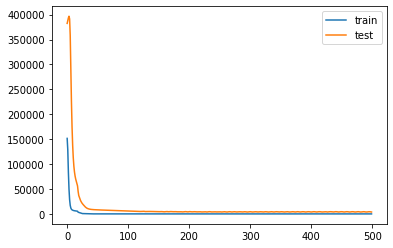

In [10]:
plt.plot(history_tech.history['loss'], label='train')
plt.plot(history_tech.history['val_loss'], label='test')
plt.legend()

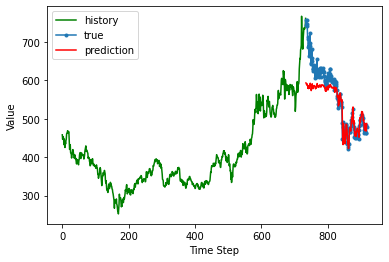

In [11]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

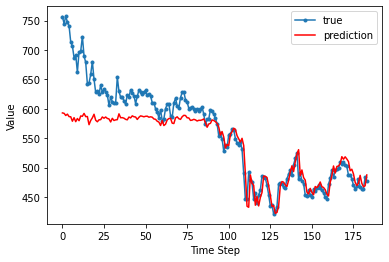

In [12]:
# y_test = sc.inverse_transform(y_test)
# y_pred = sc.inverse_transform(y_pred)
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [13]:
r2_score(y_test,y_pred)

0.6935009076748797

In [14]:
mean_absolute_percentage_error(y_test,y_pred)

0.048354507167225974

In [15]:
mean_squared_error(y_test,y_pred,squared=False)

45.30530911687907

In [17]:
x_val=data_val.drop(['Prediction','OSC12','OSC6','MI12','MI6','Volume','%R10','%R5','RSI','TR'],1)
y_val=data_val['Prediction']
x_val=sc.transform(x_val).reshape(x_val.shape[0],1,x_val.shape[1])
y_val_pred=model_tech.predict(x_val)

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_61294/3166683143.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_val=data_val.drop(['Prediction','OSC12','OSC6','MI12','MI6','Volume','%R10','%R5','RSI','TR'],1)


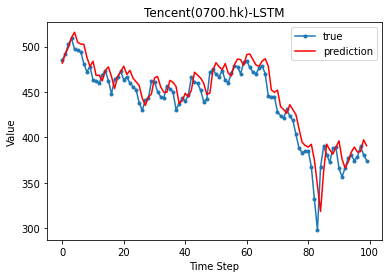

In [18]:
plt.plot(y_val.values, marker='.', label="true")
plt.plot(y_val_pred, 'r',label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.title('Tencent(0700.hk)-LSTM')
plt.legend()
plt.show()

In [19]:
r2_score(y_val,y_val_pred)

0.8721354936757989

In [20]:
mean_absolute_percentage_error(y_val,y_val_pred)

0.027600327598524838

In [21]:
mean_squared_error(y_val.values,y_val_pred,squared=False)

15.057861203107493